## Aprenentatge autmátic - Práctica 1
### Classificació d'imatges emprant SVM

L'objectiu d'aquesta primera pràctica de l'assignatura aprenentatge automàtic es l'obtenció del millor SVM possible, hem obtat per el dataset dels paissatges ja que creim que aprendrem més i que ens servirà per a la realització del TFG.

Com ens indiquen a l'encunciat tenim un conjunt d'imatges en una escala de grisos sense gaire preprocesament, les imatges ja venen separades en el test amb unes 3100 mostres i el train amb unes 1500 imatges, això de primeres ens sorpren una mica ja que tenim mes mostres de test (~2/3) que de train.

El primer que farem sera mirar les nostres dades i extreure informació que ens pugi ser útil.

In [1]:
import matplotlib.pyplot as plt
from matplotlib.image import imread
from skimage.feature import hog
from skimage import data, exposure, feature, io, color
import os
import pandas as pd
import seaborn as sns
import warnings
from sklearn.metrics import accuracy_score , confusion_matrix
import cv2 as cv

from sklearn.svm import SVC
warnings.filterwarnings('ignore')

## Tractament i exploració de dades

El primer que farem sera mirar quines categories d'imatges tenim i visualitzarem una imatge de cada cateogria.

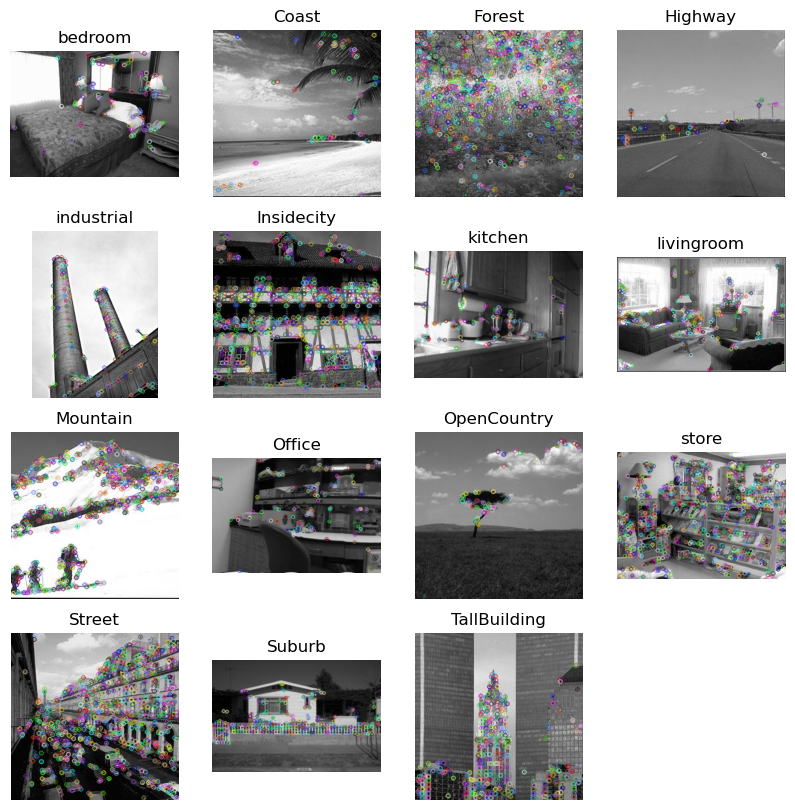

In [2]:
test_path = 'a2/test'
train_path = 'a2/train'

categories = os.listdir(train_path)

def show_categories(categories, train_path):
    plt.figure(figsize=(10, 10))
    for i, category in enumerate(categories):
        image_path = os.path.join(train_path, category)
        image_in_folder = os.listdir(image_path)
        first_image = image_in_folder[0]
        first_image_in_path = os.path.join(image_path, first_image)
        img = imread(first_image_in_path)
        plt.subplot(4, 4, i + 1)
        
        fast = cv.FastFeatureDetector_create(50)
        kp = fast.detect(img,None)
        fast_image=cv.drawKeypoints(img,kp,img)
        plt.imshow(fast_image);

        # plt.imshow(img, cmap='gray')
        plt.title(category)
        plt.axis('off')
    plt.show()

show_categories(categories, train_path)

Com podem observar tenim un total de 15 categories difrents i molt variades, desde d'interior d'una tenda com una carretera o una muntaña, el seguent pas que farem sera convertir les imatges a un dataset, per això recorrerem totes les imatges i les tranformarem a un vector unideimensional emprant la funció `flatten()` del paquet `NumPy`, en el nostre cas s'obté un vector unidimensional que conté tots els valors de píxels de la imatge en una seqüència lineal.

In [3]:
from skimage import io, transform

def convertImageData(categories, data_path):
    # Definir listas para almacenar datos
    data = []
    labels = []

    # Tamaño de redimensionamiento deseado
    new_size = (75, 75)

    # Recorrer cada categoría
    for category in categories:
        path = os.path.join(data_path, category)
        for img in os.listdir(path):
            img_path = os.path.join(path, img)
            image = io.imread(img_path)
            # Redimensionar la imagen
            resized_image = transform.resize(image, new_size)
            # Aplanar la imagen en un vector unidimensional
            feature_vector = resized_image.flatten()

            # Agregar el vector de características y la etiqueta a las listas de datos
            data.append(feature_vector)
            labels.append(categories.index(category))

    return data, labels

data, labels = convertImageData(categories, train_path)

df = pd.DataFrame(data)
df['label'] = labels

# Mostrar el DataFrame
print(df)

             0         1         2         3         4         5         6  \
0     0.792946  0.679667  0.524123  0.387273  0.324964  0.353837  0.356325   
1     0.733878  0.703124  0.694205  0.689287  0.696465  0.880840  0.973866   
2     0.853155  0.855165  0.858404  0.857528  0.850995  0.836916  0.818450   
3     0.208021  0.220134  0.227422  0.234111  0.249135  0.259677  0.269650   
4     0.759015  0.771203  0.780220  0.776727  0.767168  0.757085  0.744529   
...        ...       ...       ...       ...       ...       ...       ...   
1494  0.541855  0.556096  0.574367  0.574486  0.579620  0.579069  0.568830   
1495  0.313509  0.318124  0.319171  0.330469  0.345008  0.325756  0.367347   
1496  0.134125  0.137306  0.134899  0.139204  0.143643  0.145674  0.145703   
1497  0.228056  0.233338  0.236573  0.236371  0.242635  0.243809  0.252381   
1498  0.184579  0.158165  0.103657  0.090603  0.157132  0.194428  0.155436   

             7         8         9  ...      5616      5617    

Ara que ja tenim totes les imatges a un dataframe amb els valors convertits podem visualitzar quin percentatje de dades tenim de cada categoria, per els gràfics emprarem la llibreria Seaborn. 

label
1     6.671114
2     6.671114
3     6.671114
4     6.671114
5     6.671114
6     6.671114
7     6.671114
8     6.671114
9     6.671114
10    6.671114
11    6.671114
12    6.671114
13    6.671114
14    6.671114
0     6.604403
Name: proportion, dtype: float64


<Axes: xlabel='label', ylabel='count'>

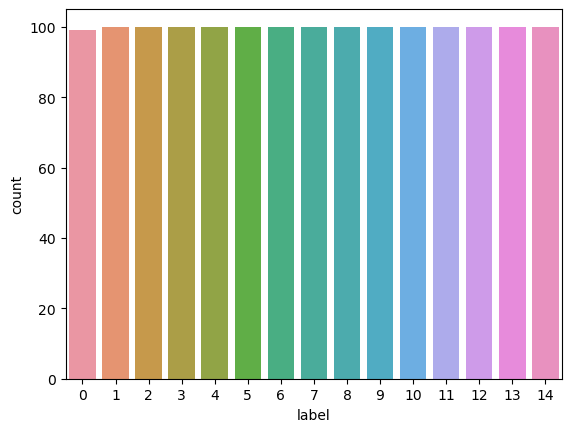

In [4]:
percentage = df['label'].value_counts(normalize=True) * 100
print(percentage)
# Crear el gráfico de barras con los porcentajes
sns.countplot(x="label", data=df)

Com podem observar el percentatje de cada categoria es molt parescut, si no casi identic, això en indica que tenim un porcentatge de dades molt ben balancetjat.

Provarem a fer un SVM basic sense fer cap modificació a les dades i observarem quins resultats ens dona.

In [5]:
svm_basic = SVC(random_state=33, probability=True)

x_train = df.iloc[:,:-1]  
y_train = df.iloc[:,-1]

svm_basic.fit(x_train, y_train) 

SVC(probability=True, random_state=33)

In [6]:
data, labels = convertImageData(categories, test_path)

y_pred = svm_basic.predict(data) 
# Calculating the accuracy of the model 
accuracy = accuracy_score(y_pred, labels) 
  
# Print the accuracy of the model 
print(f"The model is {accuracy*100}% accurate")

The model is 31.256281407035175% accurate


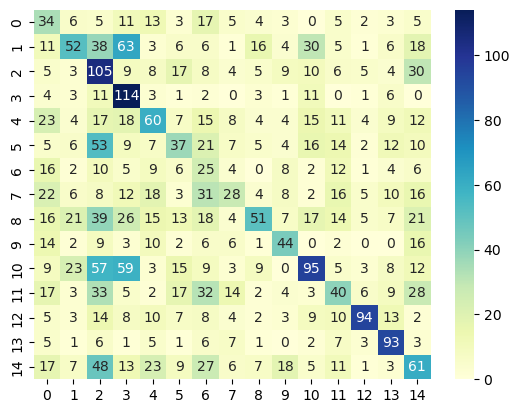

In [7]:
cf_matrix = confusion_matrix(labels, y_pred)
sns.heatmap(cf_matrix, annot=True, fmt='d', cmap='YlGnBu')
plt.show()    

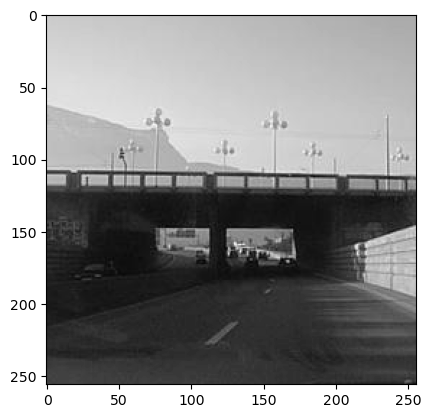

bedroom = 1.2451917852160461%
Coast = 10.922892441761826%
Forest = 0.9782654413434695%
Highway = 21.139961095268724%
industrial = 11.678282973068018%
Insidecity = 7.605481082441106%
kitchen = 1.0888206120477109%
livingroom = 7.09781004135091%
Mountain = 8.727748197353586%
Office = 0.5365009451307281%
OpenCountry = 22.85871775695218%
store = 0.6887241420567464%
Street = 2.707749287178557%
Suburb = 0.7506071651670937%
TallBuilding = 1.973247033663318%
The predicted image is : Highway


In [8]:
image = imread('a2/test/highway/image_0136.jpg')
plt.imshow(image, cmap="gray") 
plt.show() 
img_resize = transform.resize(image,(75,75)) 
l=[img_resize.flatten()] 
probability=svm_basic.predict_proba(l) 
for ind,val in enumerate(categories): 
    print(f'{val} = {probability[0][ind]*100}%') 
print("The predicted image is : "+categories[svm_basic.predict(l)[0]])


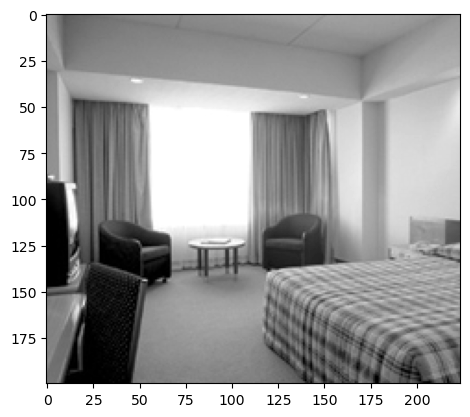

bedroom = 44.868607027039346%
Coast = 5.176085421833301%
Forest = 0.9914017662465994%
Highway = 2.8057017136373625%
industrial = 7.2064236579077%
Insidecity = 1.6184566606865574%
kitchen = 4.956591472069693%
livingroom = 12.244371220829962%
Mountain = 4.583678062508905%
Office = 2.6883411755117734%
OpenCountry = 1.4180063104315215%
store = 3.418523565851761%
Street = 1.9653402003682559%
Suburb = 1.5116889066158001%
TallBuilding = 4.546782838461443%
The predicted image is : bedroom


In [9]:
image = imread('test.jpg')
plt.imshow(image, cmap="gray") 
plt.show() 
img_resize = transform.resize(image,(75,75)) 
l=[img_resize.flatten()] 
probability=svm_basic.predict_proba(l) 
for ind,val in enumerate(categories): 
    print(f'{val} = {probability[0][ind]*100}%') 
print("The predicted image is : "+categories[svm_basic.predict(l)[0]])


Ara provarem a fer un preprocesament de les dades per intentar millorar els resultats, per això aplicarem HOG a les imatges i repetirem el procés.

In [39]:
from skimage.feature import hog

def convertImageDataHOG(categories, data_path):
    # Definir listas para almacenar datos
    data = []
    labels = []

    # HOG parameters
    orientations = 9
    pixels_per_cell = (4, 4)
    cells_per_block = (1, 1)

    # Resize the image
    new_size = (150,150)
    
    # Recorrer cada categoría
    for category in categories:
        path = os.path.join(data_path, category)
        for img in os.listdir(path):
            img_path = os.path.join(path, img)
            image = io.imread(img_path)
            # Redimensionar la imagen
            resized_image = transform.resize(image, new_size)
            # Aplicar HOG al resized_image
            hog_features = hog(resized_image,
                               orientations=orientations,
                               pixels_per_cell=pixels_per_cell,
                               cells_per_block=cells_per_block,
                               visualize=False)

            # Agregar el vector de características HOG y la etiqueta a las listas de datos
            data.append(hog_features)
            labels.append(categories.index(category))

    return data, labels

dataHOG, labelsHOG = convertImageDataHOG(categories, train_path)

dfHOG = pd.DataFrame(dataHOG)
dfHOG['label'] = labelsHOG

# Mostrar el DataFrame
print(dfHOG)

             0         1         2         3         4         5         6  \
0     0.549658  0.289275  0.000000  0.000000  0.549658  0.549658  0.099734   
1     0.658282  0.000000  0.000000  0.000000  0.160913  0.000000  0.132858   
2     0.067791  0.000000  0.000000  0.000000  0.997700  0.000000  0.000000   
3     0.447219  0.447219  0.447219  0.000000  0.447219  0.254773  0.222851   
4     0.381029  0.071923  0.000000  0.229209  0.892809  0.000000  0.000000   
...        ...       ...       ...       ...       ...       ...       ...   
1494  0.501703  0.337251  0.221059  0.501703  0.501703  0.000000  0.000000   
1495  0.456687  0.238278  0.000000  0.594502  0.594502  0.000000  0.000000   
1496  0.427414  0.427414  0.323893  0.405414  0.427414  0.427414  0.000000   
1497  0.988555  0.000000  0.000000  0.000000  0.150858  0.000000  0.000000   
1498  0.499488  0.000000  0.045238  0.000000  0.499488  0.499488  0.499488   

             7         8         9  ...         12312     12313

In [ ]:
svm_HOG = SVC(random_state=33, probability=True)

x_train_hog = dfHOG.iloc[:,:-1]  
y_train_hog = dfHOG.iloc[:,-1]

svm_HOG.fit(x_train_hog, y_train_hog) 

In [12]:
dataHOG, labelsHOG = convertImageDataHOG(categories, test_path)

y_pred_hog = svm_HOG.predict(dataHOG) 
# Calculating the accuracy of the model 
accuracy_hog = accuracy_score(y_pred_hog, labelsHOG) 
  
# Print the accuracy of the model 
print(f"The model is {accuracy_hog*100}% accurate")

The model is 61.74204355108878% accurate


In [18]:
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import KFold

# Define the parameter grid for the grid search
param_grid = {'C': [1, 10, 100],
              'gamma': ["auto", "scale"],
              'kernel': ['rbf', 'linear', "poly"]}

# Create the GridSearchCV object
grid_search = GridSearchCV(SVC(random_state=33, probability=True), param_grid, verbose=3, cv=KFold(n_splits=5, random_state=10, shuffle=True))

# Fit the grid search to the data
grid_search.fit(x_train_hog, y_train_hog)

# Print the best parameters and best score
print("Best parameters:", grid_search.best_params_)
print("Best score:", grid_search.best_score_)


Fitting 10 folds for each of 18 candidates, totalling 180 fits
[CV 1/10] END ......C=1, gamma=auto, kernel=rbf;, score=0.033 total time=   0.8s
[CV 2/10] END ......C=1, gamma=auto, kernel=rbf;, score=0.033 total time=   0.8s
[CV 3/10] END ......C=1, gamma=auto, kernel=rbf;, score=0.033 total time=   0.8s
[CV 4/10] END ......C=1, gamma=auto, kernel=rbf;, score=0.133 total time=   0.8s
[CV 5/10] END ......C=1, gamma=auto, kernel=rbf;, score=0.080 total time=   0.8s
[CV 6/10] END ......C=1, gamma=auto, kernel=rbf;, score=0.027 total time=   0.8s
[CV 7/10] END ......C=1, gamma=auto, kernel=rbf;, score=0.067 total time=   0.8s
[CV 8/10] END ......C=1, gamma=auto, kernel=rbf;, score=0.147 total time=   0.8s
[CV 9/10] END ......C=1, gamma=auto, kernel=rbf;, score=0.027 total time=   0.8s
[CV 10/10] END .....C=1, gamma=auto, kernel=rbf;, score=0.020 total time=   0.8s
[CV 1/10] END ...C=1, gamma=auto, kernel=linear;, score=0.600 total time=   0.3s
[CV 2/10] END ...C=1, gamma=auto, kernel=linea

In [20]:
svm_HOG_grid = SVC(C=1.0, gamma="scale", kernel='rbf', random_state=33, probability=True)

svm_HOG_grid.fit(x_train_hog, y_train_hog) 

y_pred_hog = svm_HOG_grid.predict(dataHOG) 
# Calculating the accuracy of the model 
accuracy_hog_grid = accuracy_score(y_pred_hog, labelsHOG) 
  
# Print the accuracy of the model 
print(f"The model is {accuracy_hog_grid*100}% accurate")

The model is 61.74204355108878% accurate


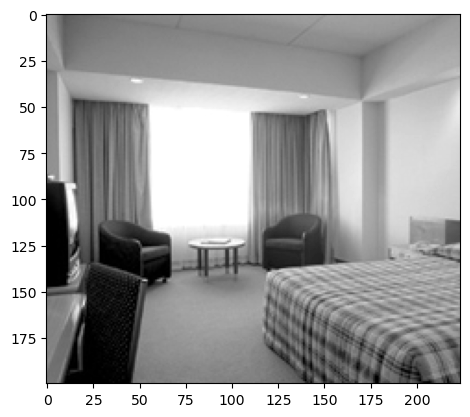

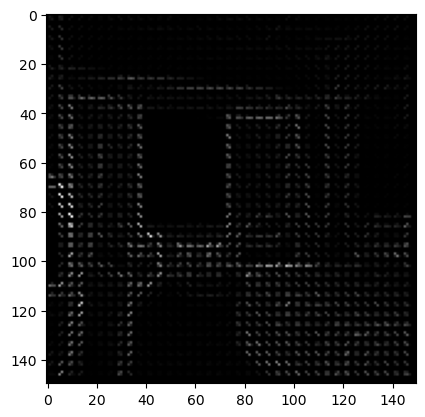

ValueError: X has 12321 features, but SVC is expecting 272 features as input.

In [37]:
# Load the image
image = imread('test.jpg')
plt.imshow(image, cmap="gray")
plt.show()

# HOG parameters
orientations = 9
pixels_per_cell = (4, 4)
cells_per_block = (1, 1)

# Resize the image
img_resize = transform.resize(image, (150, 150))

# Calculate HOG features
hog_features, hog_image = hog(img_resize,
                              orientations=orientations,
                              pixels_per_cell=pixels_per_cell,
                              cells_per_block=cells_per_block,
                              visualize=True)

# Visualize HOG features
plt.imshow(hog_image, cmap="gray")
plt.show()

# Use the trained SVM model for prediction
probability = svm_HOG.predict_proba([hog_features])

# Show the prediction results
for ind, val in enumerate(categories):
    print(f'{val} = {probability[0][ind] * 100}%')

# Print the predicted image
print("The predicted image is: " + categories[svm_HOG.predict([hog_features])[0]])


---
DUBTES:
Juntar train i test per anar jugant amb diferents valors de separació


